# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as tc
from torch import nn
from preprocess import preprocess_dataframe, make_tensordata
from visual import plot_demo, plot_series
from model import train_model, LSTMModel
from analysis import plot_Kp_correlation, plot_Kp_persistence

# Load and concat annual data

In [139]:
dtype = np.float64
yrs = range(2016, 2023)

dfs = []
for yr in yrs:
    yr_df = pd.read_csv(f'model_data/model_{yr}_1min_data.csv', index_col='t', parse_dates=True, dtype=dtype)
    dfs.append(yr_df) 
orig_df = pd.concat(dfs)

# Preprocess (resample time resolution, split, standardize, fill nan) data

In [140]:
t_res = pd.Timedelta('1hr')
split_ratio=0.75
fill_nan_val=0

train_df, test_df, train_mean, train_std = preprocess_dataframe(orig_df, t_res, split_ratio, fill_nan_val)

# Make tensordata

In [141]:
input_window = 24 # 24hr
offset = 3 # 3hr
label_window = 1 # one-point

train_inputs, train_labels, test_inputs, test_labels = make_tensordata(
    train_df, 
    test_df, 
    label_col_names=['Kp'], 
    input_window=input_window, 
    label_window=label_window, 
    offset=offset
)

# Train model or load model

## Initialize

In [ ]:
hidden_size = 128

# Load model:
# lstm_model = torch.load('trained_model/3hr_lastm_model.pt')
lstm_model = LSTMModel(hidden_size=hidden_size, feature_size=len(train_df.columns), input_window=input_window, label_window=label_window)

plot_series(
    test_df, 
    train_mean, 
    train_std, 
    start=-100, 
    end=None, 
    input_window=input_window, 
    label_window=label_window, 
    offset=offset, 
    model=lstm_model,
    pred_type='both'
)

## Train

Epoch 1 RMSE: (train, test) = (0.4808596, 0.3361948)
Epoch 2 RMSE: (train, test) = (0.4804973, 0.3365140)
Epoch 3 RMSE: (train, test) = (0.4801190, 0.3366178)


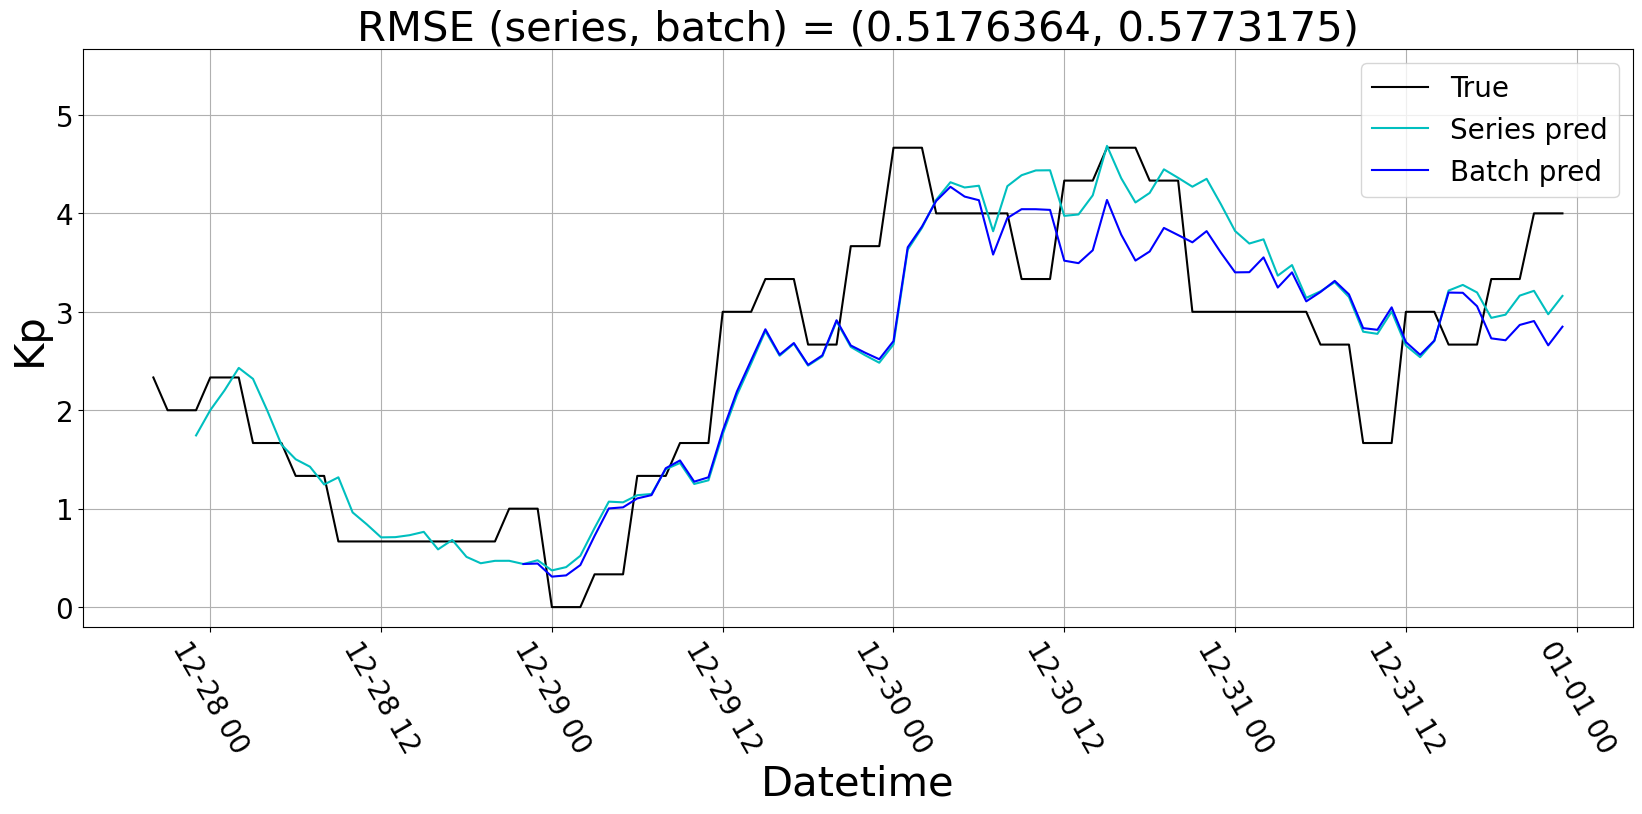

In [230]:
train_model(train_inputs, train_labels, test_inputs, test_labels, model=lstm_model, lr=1e-5, n_epoch=3, batch_size=2048)

plot_series(
    test_df, 
    train_mean, 
    train_std, 
    start=-100, 
    end=None, 
    input_window=input_window, 
    label_window=label_window, 
    offset=offset, 
    model=lstm_model,
    pred_type='both'
)

# Test model

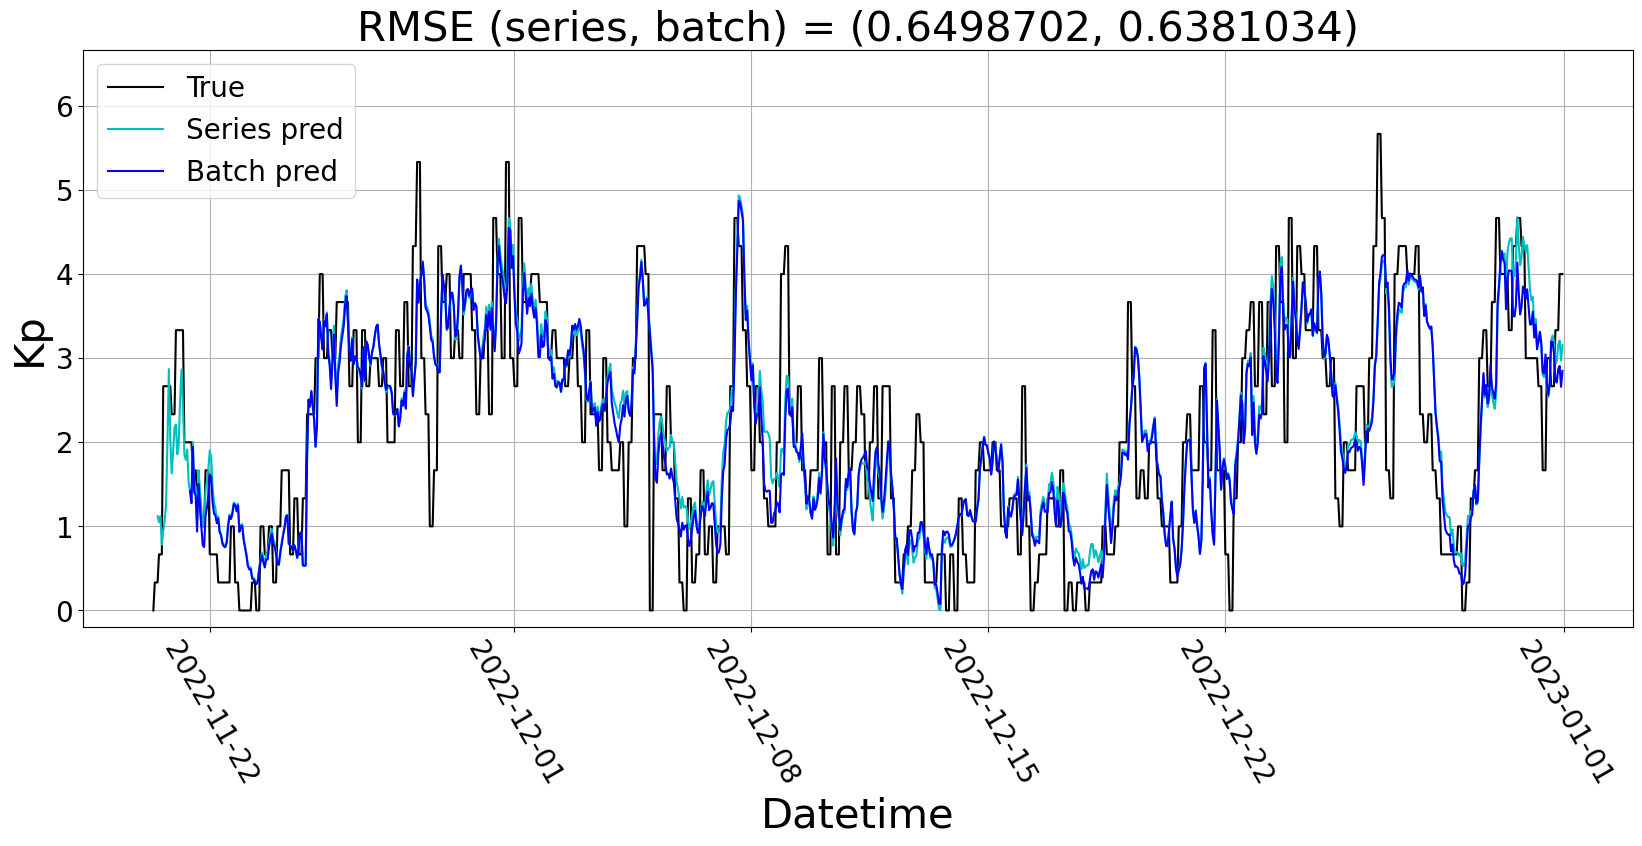

In [248]:
plot_series(
    test_df, 
    train_mean, 
    train_std, 
    start=-1000, 
    end=None, 
    input_window=input_window, 
    label_window=label_window, 
    offset=offset, 
    model=lstm_model,
    pred_type='both'
)

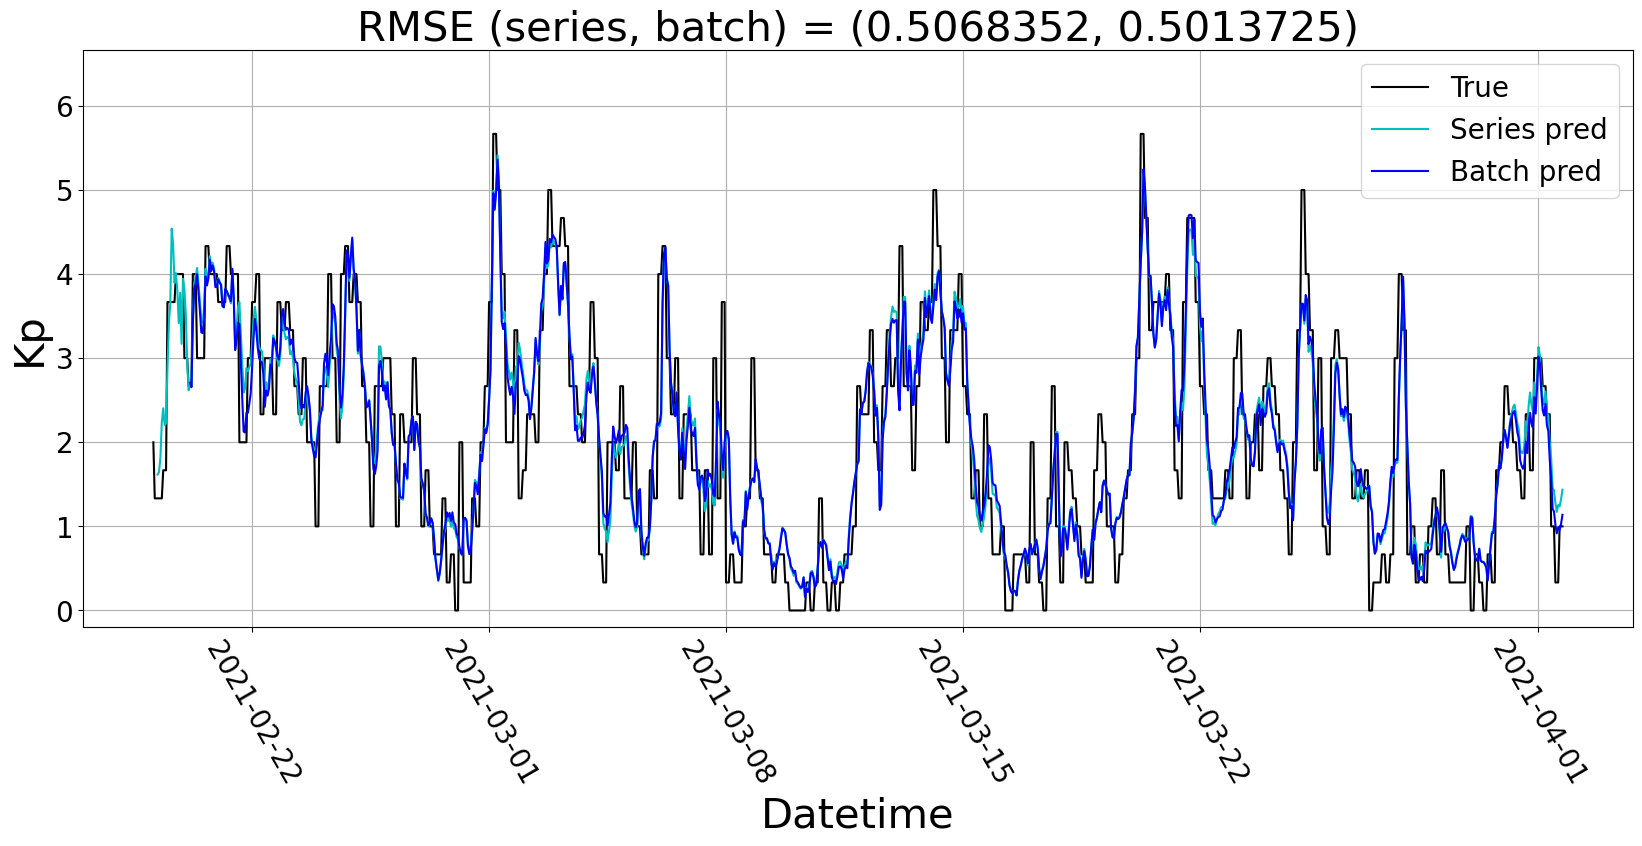

In [249]:
plot_series(
    train_df, 
    train_mean, 
    train_std, 
    start=-1000, 
    end=None, 
    input_window=input_window, 
    label_window=label_window, 
    offset=offset, 
    model=lstm_model,
    pred_type='both'
)

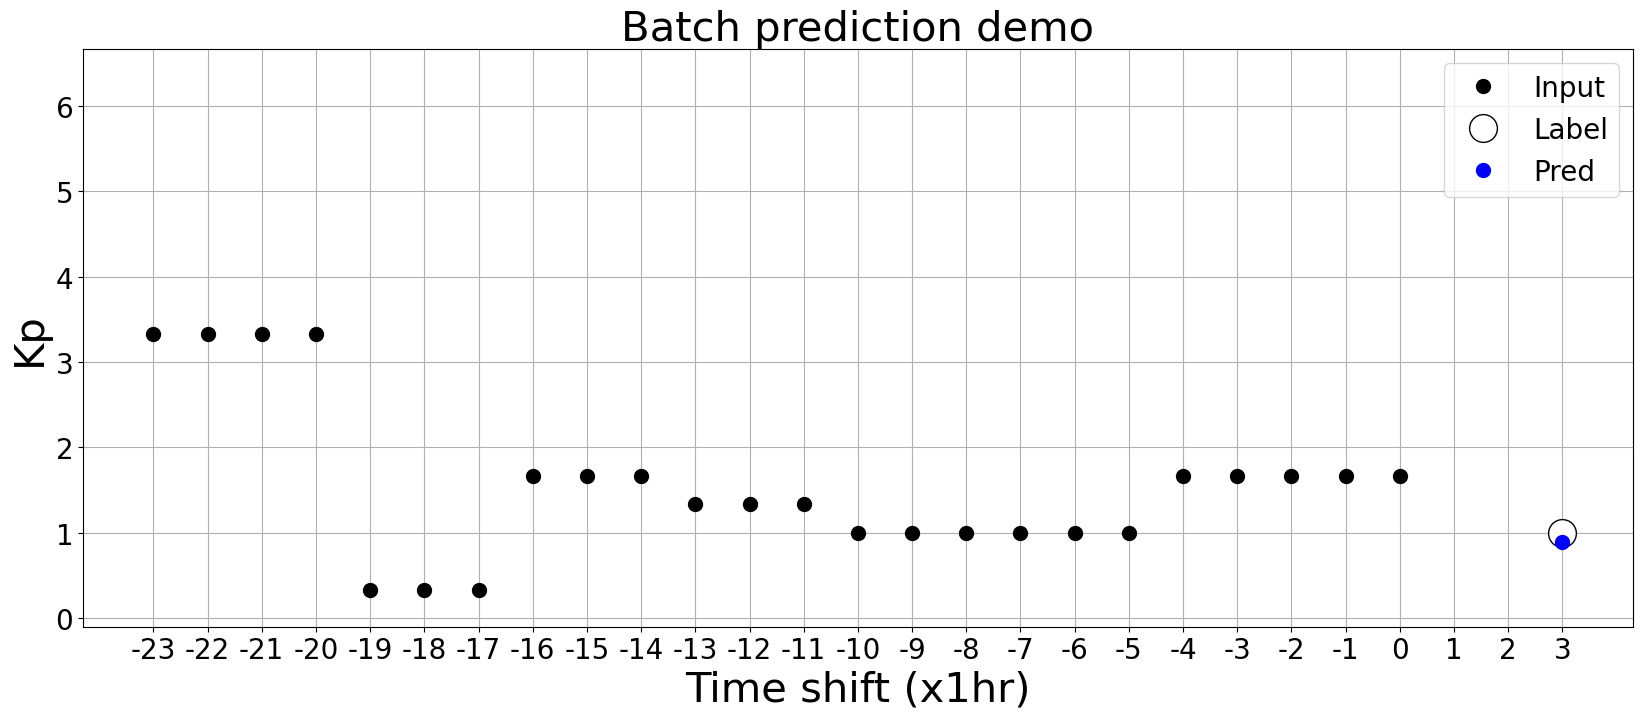

In [203]:
plot_demo(
    test_df, 
    train_mean, 
    train_std, 
    label_col_names=['Kp'], 
    plot_col_name='Kp',
    t_res='1hr',
    input_window=input_window, 
    label_window=label_window, 
    offset=offset,
    max_demos=1,
    model=lstm_model
)

# Save model

In [233]:
#tc.save(lstm_model, f='model/3hr_lstm_model.pth')

# Kp correlation

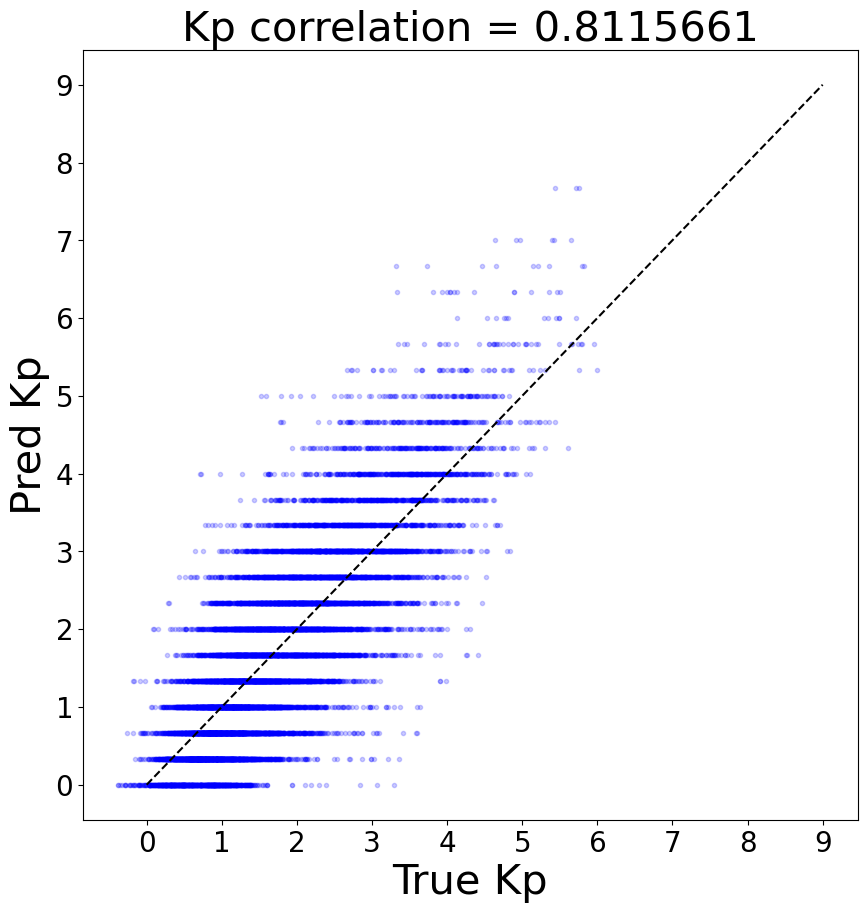

In [245]:
plot_Kp_correlation(test_df, input_col_names=None, mean=train_mean['Kp'], std=train_std['Kp'], model=lstm_model, input_window=input_window, label_window=label_window, offset=offset)

# Kp persistence

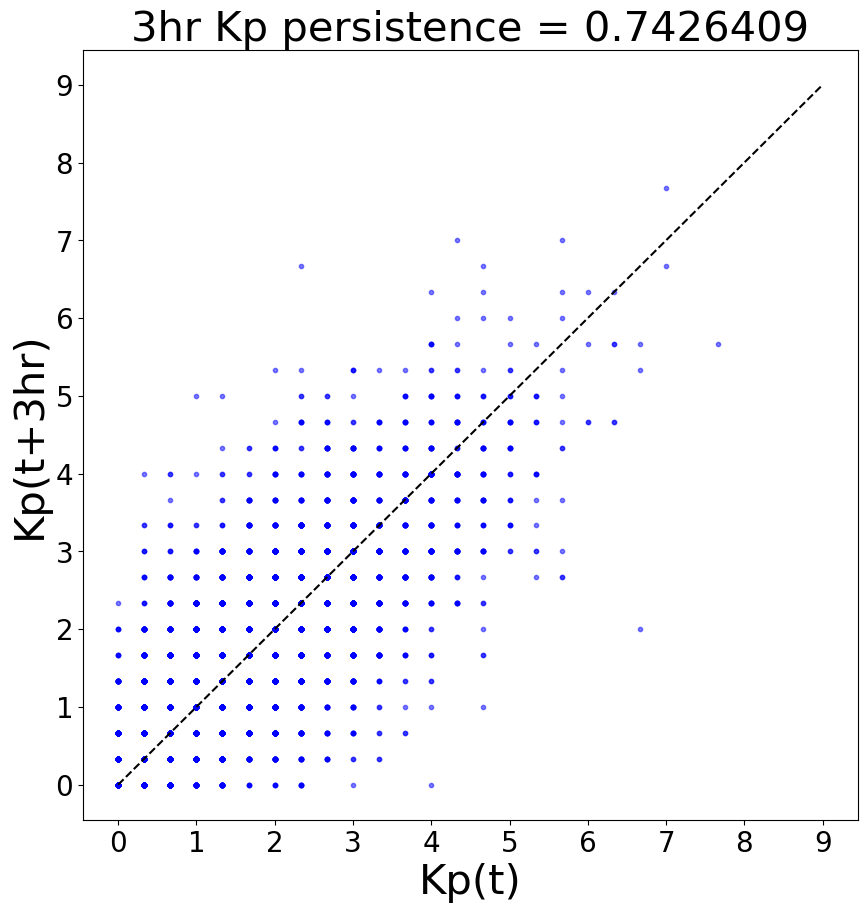

In [260]:
plot_Kp_persistence(test_df, mean=train_mean['Kp'], std=train_std['Kp'], hr_shift=3)

# Gradient analysis

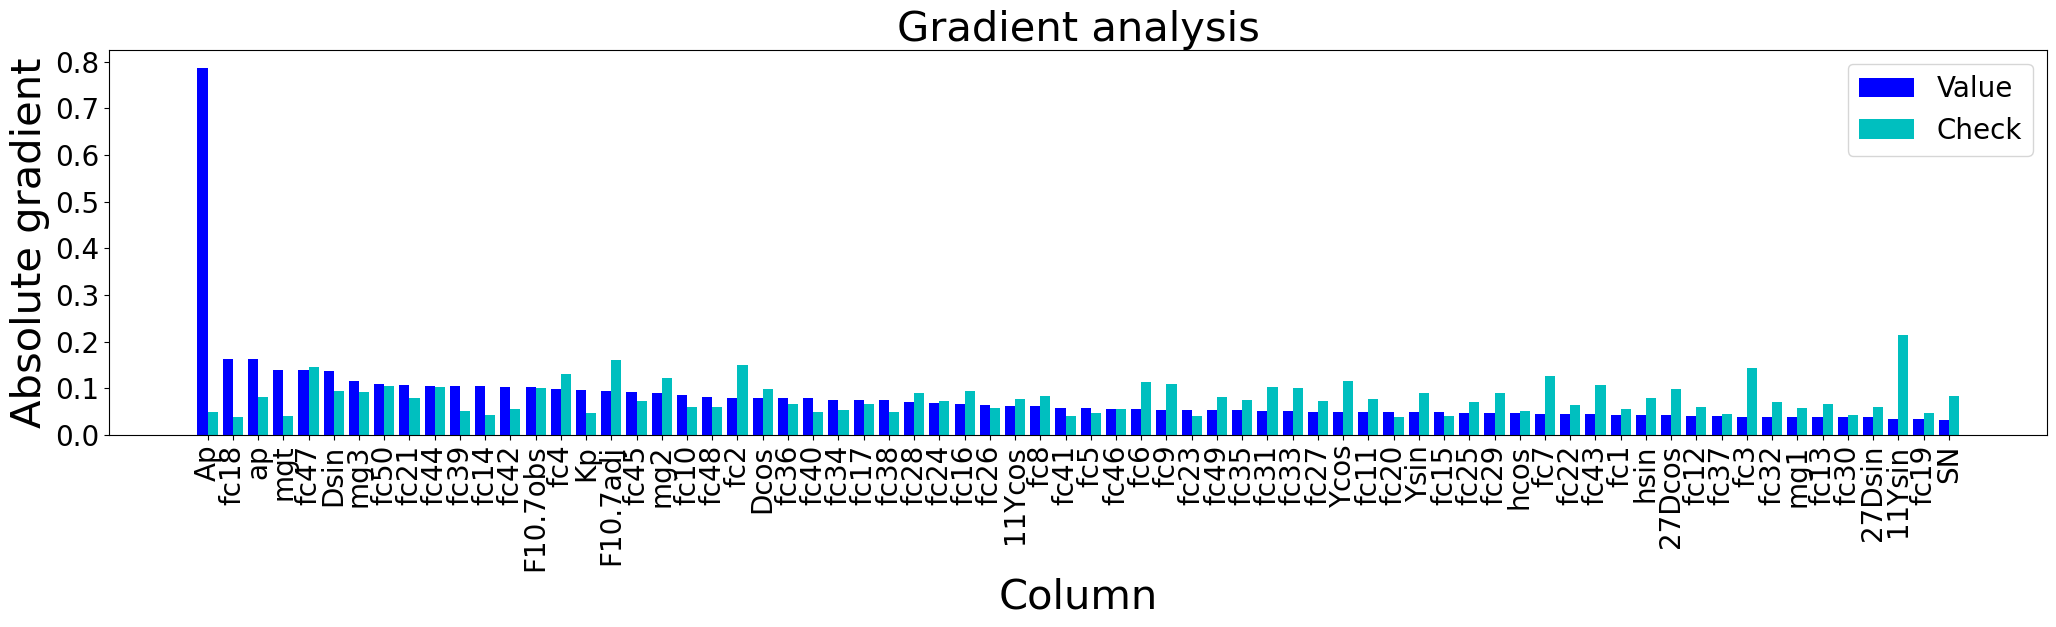

In [251]:
def grad_analysis(df, input_col_names, mean, std, model, input_window, label_window, offset):
    loss_fn = nn.MSELoss()
    input_col_names = input_col_names
    if input_col_names is None:
        input_col_names = [name for name in df.columns]

    start_idxs = range(0, len(df) - input_window - offset - label_window + 2)

    n_feature = len(df.columns)
    grad_running_sum = np.zeros(n_feature)

    for i in start_idxs:
        input_idx = slice(i, i + input_window)
        input = tc.tensor(np.expand_dims(df[input_col_names][input_idx], 0), requires_grad=True)
        pred = model(input)

        #label_idx = slice(i + input_window + offset - 1, i + input_window + offset - 1 + label_window)
        #label = tc.tensor(np.expand_dims(df['Kp'][label_idx], [0, 1]))
        #loss = loss_fn(pred, label)

        pred.backward()
        grad = input.grad

        grad_running_sum += np.abs(grad.detach().numpy().sum(axis=1).squeeze())

    grad_running_sum /= len(start_idxs)

    n_bar = n_feature//2
    sort_idxs = grad_running_sum[:n_bar].argsort()[::-1]

    bar_width = 0.4
    
    bar_idxs = np.arange(n_bar)
    plt.figure(figsize=(25, 5))
    plt.title('Gradient analysis', fontsize=30)
    plt.bar(bar_idxs, np.abs(grad_running_sum)[:n_bar][sort_idxs], color='b', width=bar_width, label='Value')
    plt.bar(bar_idxs+bar_width, np.abs(grad_running_sum)[n_bar:][sort_idxs], color='c', width=bar_width, label='Check')
    plt.xlabel('Column', fontsize=30)
    plt.ylabel('Absolute gradient', fontsize=30)
    plt.xticks(ticks=bar_idxs+bar_width/2, labels=df.columns[sort_idxs], fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

grad_analysis(test_df, input_col_names=None, mean=train_mean['Kp'], std=train_std['Kp'], model=lstm_model, input_window=input_window, label_window=label_window, offset=offset)

In [ ]:
x = tc.tensor([[2.]], requires_grad=True)
y = tc.square(x)
y.backward()
x.grad

tensor([[4.]])

In [ ]:
x = tc.tensor(np.expand_dims(test_df[0:1], 0), requires_grad=True)
print(x)
y = lstm_model(x)
print(y)
y.backward()
print(x.grad)

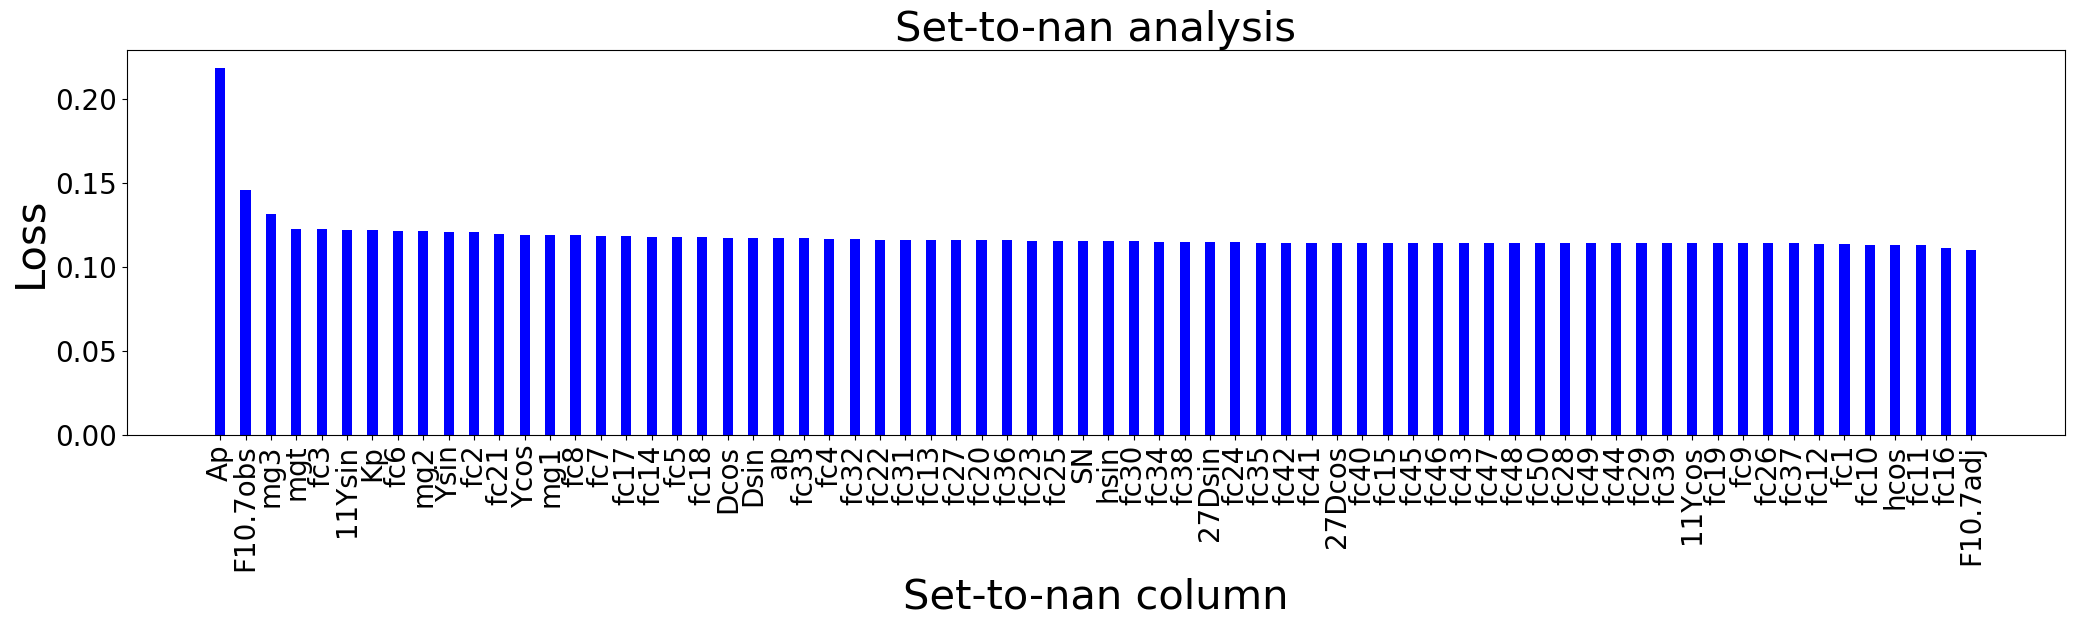

In [257]:
def nan_analysis(model, inputs, labels, col_names, mean, std):
    loss_fn = nn.MSELoss()
    losses = np.zeros(70, dtype=np.float64)
    for feature_idx in range(70):
        set_nan_inputs = inputs.clone().detach()
        set_nan_inputs[:, :, feature_idx] = 0
        set_nan_inputs[:, :, 70 + feature_idx] = 0

        loss_running_sum = 0
        for i, (input, label) in enumerate(zip(set_nan_inputs, labels)):
            input = input.unsqueeze(0)
            label = label.unsqueeze(0)
            pred = model(input)

            loss = loss_fn(pred, label)

            loss_running_sum += loss

        losses[feature_idx] = loss_running_sum / len(inputs)

    n_bar = 70
    bar_width = 0.4

    sort_idxs = losses.argsort()[::-1]
    
    bar_idxs = np.arange(n_bar)
    plt.figure(figsize=(25, 5))
    plt.title('Set-to-nan analysis', fontsize=30)
    plt.bar(bar_idxs, losses[sort_idxs], color='b', width=bar_width, label='Loss')
    plt.xlabel('Set-to-nan column', fontsize=30)
    plt.ylabel('Loss', fontsize=30)
    plt.xticks(ticks=bar_idxs, labels=col_names[:70][sort_idxs], fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    #plt.legend(fontsize=20)
    plt.show()

n = 10
nan_analysis(lstm_model, test_inputs[::n], test_labels[::n], train_df.columns, train_mean, train_std)